In [1]:
#standard imports
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn import svm
from sklearn.metrics import r2_score

from sklearn.model_selection import train_test_split

import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

#config parser
import configparser

#MyConfig.INI stores all the run time constants
config = configparser.ConfigParser()
config.read('MyConfig.INI')

['MyConfig.INI']

In [2]:
#this is the regeion of interest
lonMin = (float)(config['REGEION']['LON_MIN'])
lonMax = (float)(config['REGEION']['LON_MAX'])

latMin = (float)(config['REGEION']['LAT_MIN'])
latMax = (float)(config['REGEION']['LAT_MAX'])

print("XMin = "+str(lonMin)+"XMax = "+str(lonMax)+"YMin = "+str(latMin)+"YMax = "+str(latMax))

#FIXME get step size from somewhere else 
#our grid size is 0.01*0.01
xGrid = np.arange(lonMin,lonMax,0.01)
xGrid = np.around(xGrid,2)
yGrid = np.arange(latMin,latMax,0.01)
yGrid = np.around(yGrid,2)

print("XGrid = ",xGrid.shape[0])
print("YGrid = ",yGrid.shape[0])

#Hourly Histogram Path
dataDirectory = config['TIME_SERIES_EXTRACT']['DATA_DIRECTORY_PATH']
#first file
dataStartIndex = (int)(config['TIME_SERIES_EXTRACT']['DATA_START_INDEX'])
#last file
dataEndIndex = (int)(config['TIME_SERIES_EXTRACT']['DATA_END_INDEX'])

fileNameList = []

#generate files list
#generates name of all the files
for i in range(dataStartIndex,dataEndIndex):
    fileStr = dataDirectory+('%04d'%(i))+'.npy'
    fileNameList.append(fileStr)

#read ROI parameters
rOILonMin = (float)(config['TIME_SERIES_EXTRACT']['ROI_LON_MIN'])
rOILonMax = (float)(config['TIME_SERIES_EXTRACT']['ROI_LON_MAX'])

rOILatMin = (float)(config['TIME_SERIES_EXTRACT']['ROI_LAT_MIN'])
rOILatMax = (float)(config['TIME_SERIES_EXTRACT']['ROI_LAT_MAX'])

#now based on ROI boundaries
#lets try to identify x and y values of the cell
print(rOILonMin,rOILonMax)
print(rOILatMin,rOILatMax)
rOILonMinIndex = np.where(xGrid == rOILonMin)
rOILonMaxIndex = np.where(xGrid == rOILonMax)

rOILatMinIndex = np.where(yGrid == rOILatMin)
rOILatMaxIndex = np.where(yGrid == rOILatMax)

#FIXME check for index out of bound
print(rOILonMinIndex[0][0],rOILonMaxIndex[0][0])
print(rOILatMinIndex[0][0],rOILatMaxIndex[0][0])

XMin = -167.5XMax = -165.5YMin = 53.0YMax = 55.0
XGrid =  200
YGrid =  200
-166.65 -166.64
53.94 53.95
85 86
94 95


In [6]:
#pass bandwidth for a regeion
#and pass hour between 0 to 23
def generate_hour_region_data(bW,hour):
    global rOILonMinIndex,rOILatMaxIndex,xGrid,yGrid,fileNameList
    
    fileCounter = 0
    #now lets consider window of -BW and +BW
    #now we can get the input window slicer by adding and subtracting BW
    #we got the index of horizontal array
    rOISliceXMin = rOILonMinIndex[0][0] - bW
    #check for less than 0
    if(rOISliceXMin < 0):
        rOISliceXMin = 0
    rOISliceXMax = rOILonMinIndex[0][0] + bW
    if(rOISliceXMax > xGrid.shape[0]):
        rOISliceXMax = xGrid.shape[0]
    print(rOISliceXMin,rOISliceXMax)

    #do for y also
    rOISliceYMin = rOILatMinIndex[0][0] - bW
    #check for less than 0
    if(rOISliceYMin < 0):
        rOISliceYMin = 0
    rOISliceYMax = rOILatMinIndex[0][0] + bW
    if(rOISliceYMax > yGrid.shape[0]):
        rOISliceYMax = yGrid.shape[0]
    print(rOISliceYMin,rOISliceYMax)

    
    #Read Histogram Data
    histLabel = []
    #first read everything
    #now lets phrase time series forcasting problem as regression problem
    for fileName in fileNameList:
        
        #divide by 24 
        #reminder will give us data in that particular time
        if ((fileCounter % 24) == hour):
        
            #read data from a file
            #the histogram values considering minimum area
            histNP = np.fromfile(fileName)
            #reshape it in 2D fashion
            histNP = histNP.reshape((xGrid.shape[0],yGrid.shape[0]))
            #now slice the array 
            #here it has to be window
            #the regeion we are interested
            #and some cells which are near to this regeion

            #after that we have our own regeion
            histNPY = histNP[rOILonMinIndex[0][0]:rOILonMaxIndex[0][0],rOILatMinIndex[0][0]:rOILatMaxIndex[0][0]].copy()
            #we need to add things up for label
            histY = np.sum(histNPY)
            #append that into label
            histLabel.append(histY)
        
        #increment the file counter
        fileCounter = fileCounter + 1
        
    histLabelNP = np.asarray(histLabel)    
    histLabelNP = histLabelNP.reshape(histLabelNP.shape[0],1)
    return histLabelNP

In [8]:
hourlyTimedData = []
for i in range(0,24):
    hourlyTimedData.append(generate_hour_region_data(0,i))

85 85
94 94
85 85
94 94
85 85
94 94
85 85
94 94
85 85
94 94
85 85
94 94
85 85
94 94
85 85
94 94
85 85
94 94
85 85
94 94
85 85
94 94
85 85
94 94
85 85
94 94
85 85
94 94
85 85
94 94
85 85
94 94
85 85
94 94
85 85
94 94
85 85
94 94
85 85
94 94
85 85
94 94
85 85
94 94
85 85
94 94
85 85
94 94


In [11]:
#now lets wrie a function to plot it
#hour value should be between 0 to 23
def plot_hourly_timed_data(hourVal):
    hourlyTimedData[hourVal]
    
    plt.figure(hourVal)
    titleStr = 'Traffic from %02d:00 to %02d:00'%(hourVal,hourVal+1) 
    plt.title(titleStr)
    xAXis = np.arange(hourlyTimedData[hourVal].shape[0])
    plt.plot(xAXis,hourlyTimedData[hourVal])

/home/jcharla/.local/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


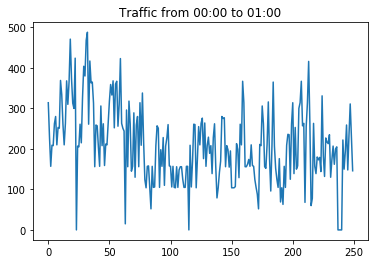

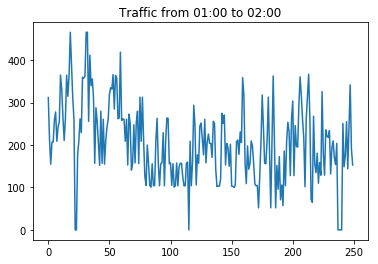

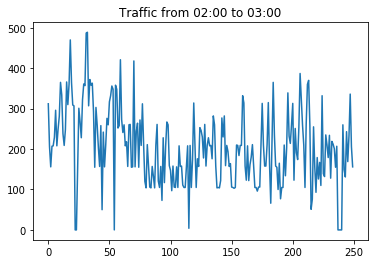

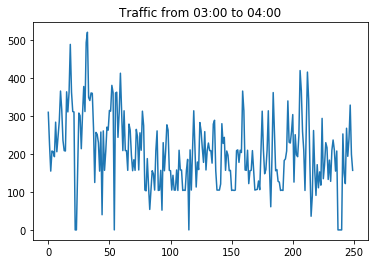

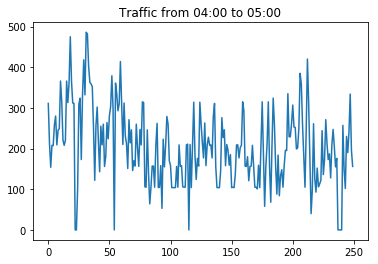

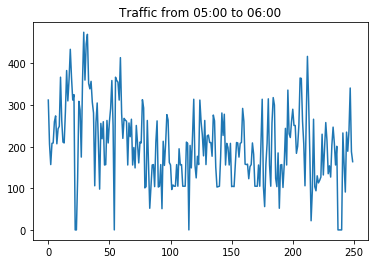

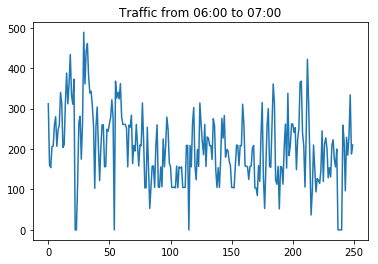

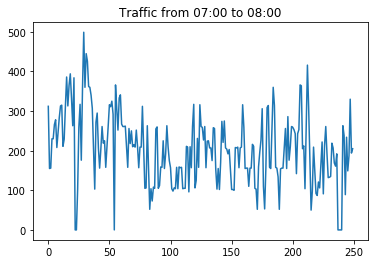

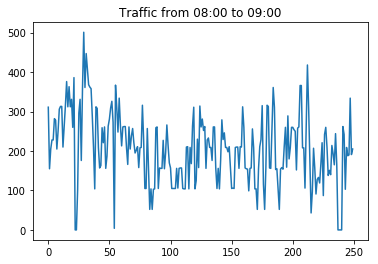

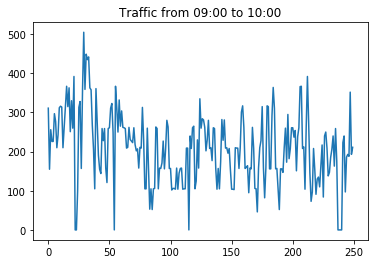

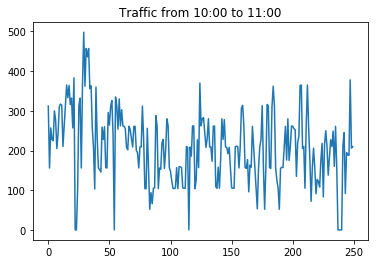

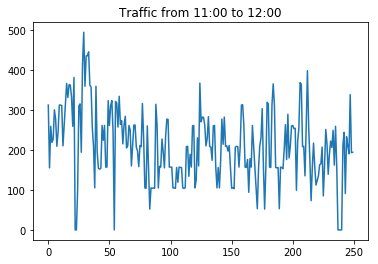

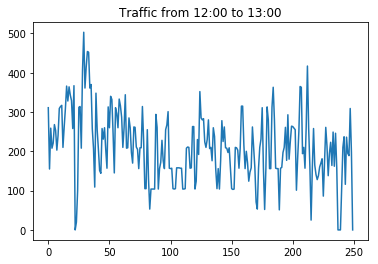

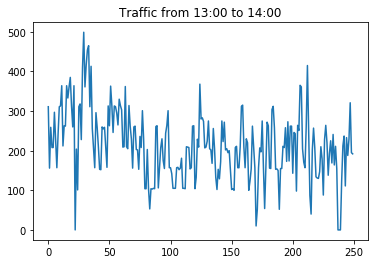

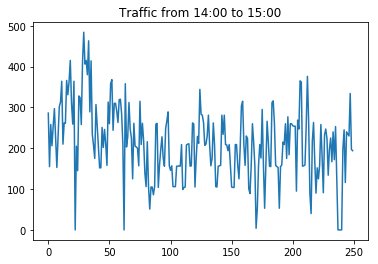

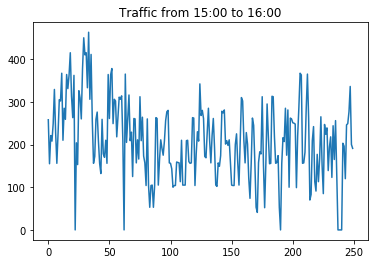

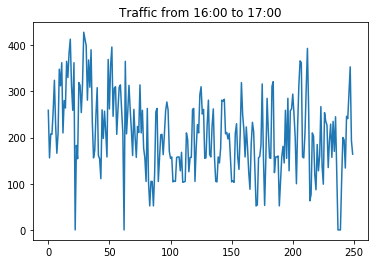

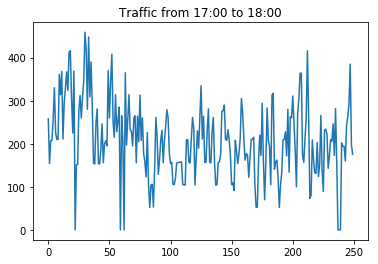

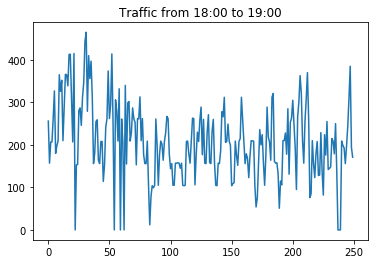

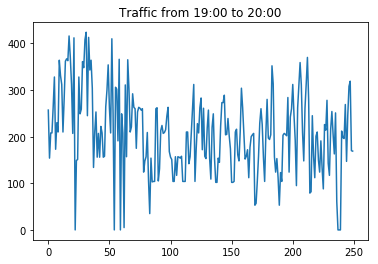

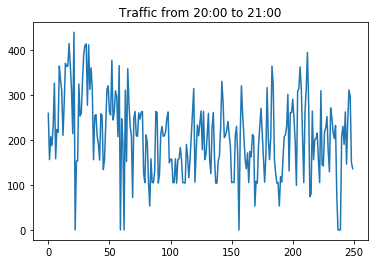

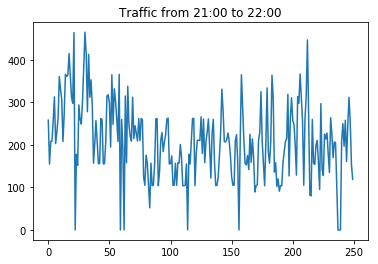

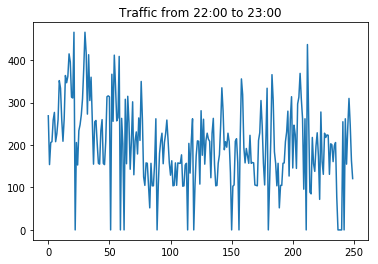

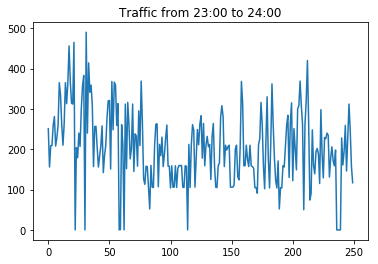

In [12]:
for i in range(0,24):
    
    plot_hourly_timed_data(i)

In [13]:
def generate_daily_region_data(bW):
    global rOILonMinIndex,rOILatMaxIndex,xGrid,yGrid,fileNameList
    
    fileCounter = 0
    #now lets consider window of -BW and +BW
    #now we can get the input window slicer by adding and subtracting BW
    #we got the index of horizontal array
    rOISliceXMin = rOILonMinIndex[0][0] - bW
    #check for less than 0
    if(rOISliceXMin < 0):
        rOISliceXMin = 0
    rOISliceXMax = rOILonMinIndex[0][0] + bW
    if(rOISliceXMax > xGrid.shape[0]):
        rOISliceXMax = xGrid.shape[0]
    print(rOISliceXMin,rOISliceXMax)

    #do for y also
    rOISliceYMin = rOILatMinIndex[0][0] - bW
    #check for less than 0
    if(rOISliceYMin < 0):
        rOISliceYMin = 0
    rOISliceYMax = rOILatMinIndex[0][0] + bW
    if(rOISliceYMax > yGrid.shape[0]):
        rOISliceYMax = yGrid.shape[0]
    print(rOISliceYMin,rOISliceYMax)

    
    #Read Histogram Data
    histLabel = []
    #first read everything
    
    histY = 0
    
    for fileName in fileNameList:
        
        if ((fileCounter % 24) == 0) and (fileCounter != 0):
            #append that into label
            histLabel.append(histY)
            histY = 0
        
        #read data from a file
        #the histogram values considering minimum area
        histNP = np.fromfile(fileName)
        #reshape it in 2D fashion
        histNP = histNP.reshape((xGrid.shape[0],yGrid.shape[0]))
        #now slice the array 
        #here it has to be window
        #the regeion we are interested
        #and some cells which are near to this regeion

        #after that we have our own regeion
        histNPY = histNP[rOILonMinIndex[0][0]:rOILonMaxIndex[0][0],rOILatMinIndex[0][0]:rOILatMaxIndex[0][0]].copy()
        #we need to add things up for label

        histY = histY + np.sum(histNPY) 
        #increment the file counter
        fileCounter = fileCounter + 1
        
    histLabelNP = np.asarray(histLabel)    
    histLabelNP = histLabelNP.reshape(histLabelNP.shape[0],1)
    return histLabelNP

85 85
94 94
84 86
93 95
83 87
92 96
82 88
91 97
81 89
90 98
80 90
89 99
79 91
88 100
78 92
87 101
77 93
86 102
76 94
85 103


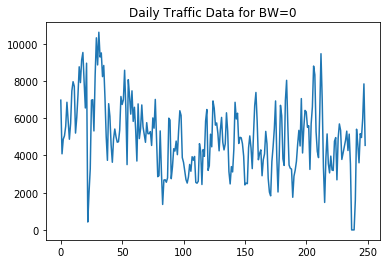

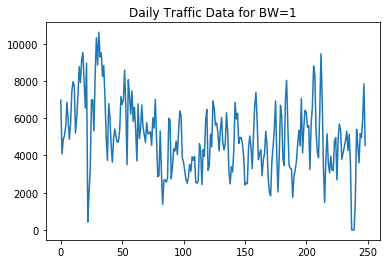

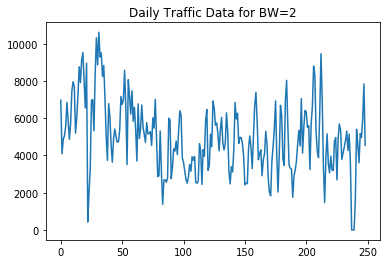

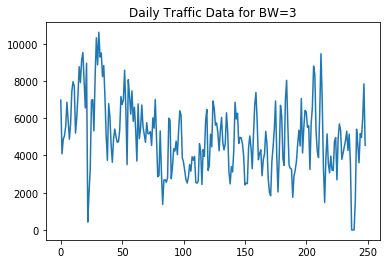

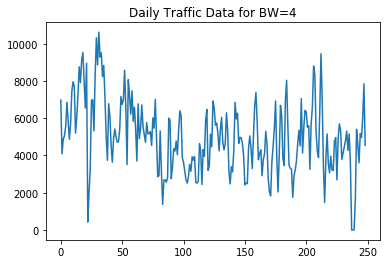

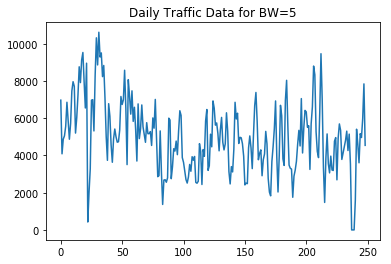

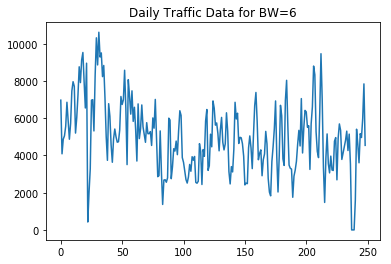

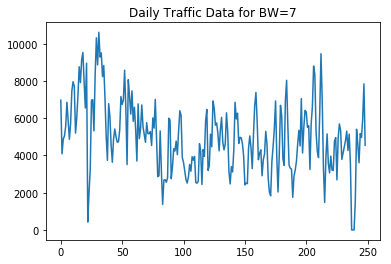

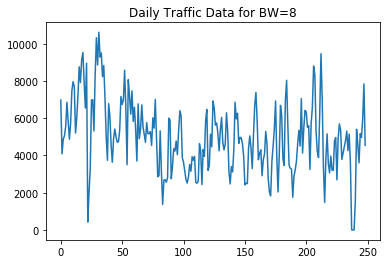

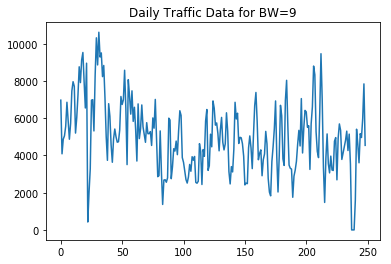

In [16]:
dailyData = []
for i in range(0,10):
    ret = generate_daily_region_data(i)
    dailyData.append(ret)
    plt.figure(i)
    titleStr = 'Daily Traffic Data for BW=%d'%(i) 
    plt.title(titleStr)
    xAXis = np.arange(ret.shape[0])
    plt.plot(xAXis,ret)

In [17]:
#the value of day of week should be between 0 to 6
def generate_week_day_region_data(dayOfWeek,bW):
    dayCounter = 0
    histLabel = []
    #we have bW based daily data
    #we need to sample them on day of week basis
    for day in dailyData[bW]:
        if ((dayCounter % 7) == dayOfWeek):
            histLabel.append(day)

        #increment the day counter
        dayCounter = dayCounter + 1
        
    histLabelNP = np.asarray(histLabel)    
    histLabelNP = histLabelNP.reshape(histLabelNP.shape[0],1)
    return histLabelNP

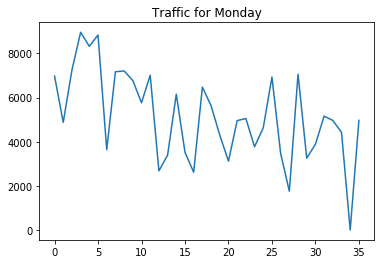

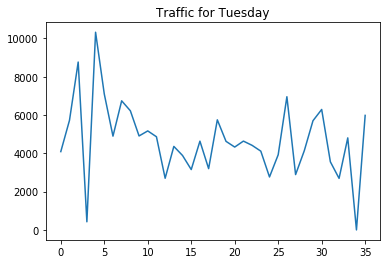

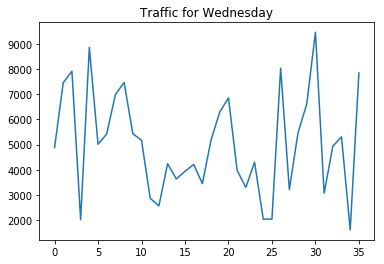

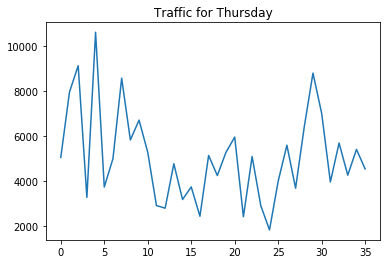

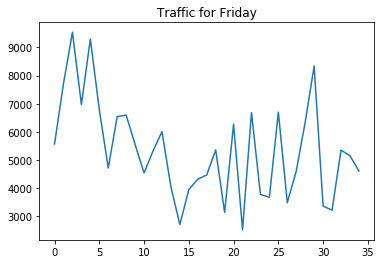

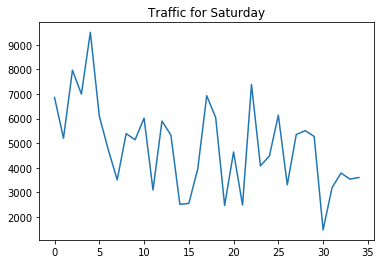

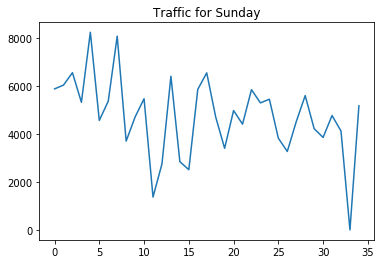

In [19]:
#plot values for day of week data
weekDict = {0:'Monday'
           ,1:'Tuesday'
           ,2:'Wednesday'
           ,3:'Thursday'
           ,4:'Friday'
           ,5:'Saturday'
           ,6:'Sunday'
           }
for i in range(0,7):
    ret = generate_week_day_region_data(i,0)
    plt.figure(i)
    titleStr = 'Traffic for %s'%(weekDict[i]) 
    plt.title(titleStr)
    xAXis = np.arange(ret.shape[0])
    plt.plot(xAXis,ret)